<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_End_To_End_MN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une couche d'attention pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def data_map(x,y):
  x1 = []
  x2 = []
  ys = []
  for i in range(0,batch_size):
    x1.append(x)
    x2.append(x[i][:])
    ys.append(y[i][:])
  return [(x1,x2),ys]

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  dataset = dataset.map(data_map)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

In [3]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)
print(mean.numpy())
print(std.numpy())

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)
print(tf.math.reduce_mean(Serie_Normalisee).numpy())
print(tf.math.reduce_std(Serie_Normalisee).numpy())

# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

90.49378905192393
43.81927756886552
2.6736603798507197e-16
1.0


In [5]:
print(len(list(dataset_norm.as_numpy_iterator())))
for element in dataset_norm.take(1):
  print(element)

30
((<tf.Tensor: shape=(32, 32, 20), dtype=float64, numpy=
array([[[-0.99343325, -0.93635495, -0.99820278, ..., -0.86781814,
         -0.9492108 , -1.07462285],
        [-0.93635495, -0.99820278, -0.81250866, ..., -0.9492108 ,
         -1.07462285, -0.89854575],
        [-0.99820278, -0.81250866, -1.12759919, ..., -1.07462285,
         -0.89854575, -0.92275185],
        ...,
        [-0.81284639, -0.971528  , -1.01684347, ..., -1.08965153,
         -1.02651943, -1.12913165],
        [-0.971528  , -1.01684347, -1.08266368, ..., -1.02651943,
         -1.12913165, -1.03877078],
        [-1.01684347, -1.08266368, -1.04162539, ..., -1.12913165,
         -1.03877078, -1.26340409]],

       [[-0.99343325, -0.93635495, -0.99820278, ..., -0.86781814,
         -0.9492108 , -1.07462285],
        [-0.93635495, -0.99820278, -0.81250866, ..., -0.9492108 ,
         -1.07462285, -0.89854575],
        [-0.99820278, -0.81250866, -1.12759919, ..., -1.07462285,
         -0.89854575, -0.92275185],
        

# Création du modèle GRU avec couche d'attention personnalisée simple

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/attention_1_ensemble2.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/attention_1_Attention2.png?raw=true" width="1200"> 

In [6]:
# Définition du de la couche du modèle
# End-to-End Memory Network
from keras import backend as K

class Couche_End_to_End_MN(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  # dim_GRU : Dimension des vecteurs GRU
  # x : Séquences à mémoriser (batch_size, Nbr_Sequence, taille_fenetre)
  # Fonction de la couche lambda d'entrée
  def __init__(self,dim_GRU):
    self.dim_GRU = dim_GRU
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    # Définition des couches GRU pour traiter les séquences d'entrée
    self.couche_GRU_A = tf.keras.layers.GRU(self.dim_GRU)
    self.couche_GRU_B = tf.keras.layers.GRU(self.dim_GRU)
    self.couche_GRU_C = tf.keras.layers.GRU(self.dim_GRU)
    self.dense = tf.keras.layers.Dense(1,use_bias=False,trainable=True)

    # Poids d'attention
    self.p = self.add_weight(shape=(input_shape[1],1),initializer="zeros",name="p")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :     x : (batch_size, Nbr_Sequence, taille_fenetre)
  #                 y : (batch_size, taille_fenetre)
  # Exemple :   batch_size = 32
  #             Nbr_Sequence =30
  #             taille_fenetre = 20
  #             dim_GRU = 40 
  def call(self,x,y):
    # Création des vecteurs mi dans le tenseur M
    M = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    M = tf.keras.layers.TimeDistributed(self.couche_GRU_A)(M)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    M = K.tanh(M)

    # Création du vecteur d'état u
    u = tf.expand_dims(y,axis=-1)                                   # (32,20) => (32,20,1)
    u = self.couche_GRU_B(u)                                        # (32,20,1) => (32,40)
    u = tf.expand_dims(u,axis=-1)                                   # (32,40) => (32,40,1)
    u = K.tanh(u)                                                   # (32,40,1)

    # Calcul des poids d'attention
    p = tf.keras.layers.Dot(axes=(2,1))([M,u])                      # (32,30,1)
    p = tf.keras.activations.softmax(p,axis=1)                      # (32,30,1)

    # Création des vecteurs ci dans le tenseur C
    C = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    C = tf.keras.layers.TimeDistributed(self.couche_GRU_C)(C)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    C = K.tanh(C)

    # Calcul du vecteur réponse issu de la mémoire
    o = tf.multiply(C,p)                                            # (32,30,40)_x_(32,30,1) = (32,30,40)
    o = K.sum(o, axis=1)                                            # (32,40)
    o = K.tanh(o)                                                   # (32,40)
    
    # Retourne le vecteur d'attention
    return (o+tf.squeeze(u,axis=2))


In [219]:
# batch_size = 3
# Nbr_Sequence = 4
# taille_fenetre = 5

x = tf.Variable([[[1,2,3,4,5],[6,7,8,9,10],[1,3,3,4,5],[1,2,3,4,5]],[[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]],[[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]],dtype=tf.float32)
y = tf.Variable([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]],dtype=tf.float32)
u = tf.Variable([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]],dtype=tf.float32)
u = tf.expand_dims(u,axis=-1)
print(x.shape)
print(y.shape)
print(u.shape)

(3, 4, 5)
(3, 5)
(3, 5, 1)


In [230]:
Couche_End_to_End_MN(dim_GRU=5)(x,y)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.3545347 , -1.0084188 ,  1.025198  ,  0.11606383, -0.7543726 ],
       [ 0.35414153, -0.9908039 ,  1.0980637 ,  0.11775899, -0.74373114],
       [ 0.35414153, -0.9908039 ,  1.0980637 ,  0.11775899, -0.74373114]],
      dtype=float32)>

In [7]:
#Nbr_Sequences = len(list(dataset_norm.as_numpy_iterator()))
Nbr_Sequences = batch_size
dim_GRU = 40

entrees_sequences = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre),batch_size=batch_size)
entrees_entrainement = tf.keras.layers.Input(shape=(taille_fenetre),batch_size=batch_size)
sortie = Couche_End_to_End_MN(dim_GRU=dim_GRU)(entrees_sequences,entrees_entrainement)
pred = tf.keras.layers.Dense(units=1)(sortie)

model = tf.keras.Model([entrees_sequences,entrees_entrainement],pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 32, 20)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 20)]           0                                            
__________________________________________________________________________________________________
couche__end_to__end_mn (Couche_ (32, 40)             15512       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (32, 1)              41          couche__end_to__end_mn[0][0] 

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [19]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [18]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-3,momentum=0.9)
#optimiseur=tf.keras.optimizers.Adam(lr=1e-3)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=50,verbose=1, callbacks=[CheckPoint,cb])

print(cb.logs)
print(sum(cb.logs))

Epoch 1/50
30/30 [==============================] - 8s 162ms/step - loss: 0.0126 - mae: 0.1204 - val_loss: 0.0139 - val_mae: 0.1244

Epoch 00001: loss improved from inf to 0.01339, saving model to poids.hdf5
Epoch 2/50
30/30 [==============================] - 4s 129ms/step - loss: 0.0117 - mae: 0.1165 - val_loss: 0.0132 - val_mae: 0.1207

Epoch 00002: loss improved from 0.01339 to 0.01246, saving model to poids.hdf5
Epoch 3/50
30/30 [==============================] - 4s 131ms/step - loss: 0.0116 - mae: 0.1161 - val_loss: 0.0126 - val_mae: 0.1179

Epoch 00003: loss improved from 0.01246 to 0.01233, saving model to poids.hdf5
Epoch 4/50
30/30 [==============================] - 4s 130ms/step - loss: 0.0116 - mae: 0.1157 - val_loss: 0.0123 - val_mae: 0.1161

Epoch 00004: loss improved from 0.01233 to 0.01227, saving model to poids.hdf5
Epoch 5/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0115 - mae: 0.1154 - val_loss: 0.0120 - val_mae: 0.1151

Epoch 00005: loss impro

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

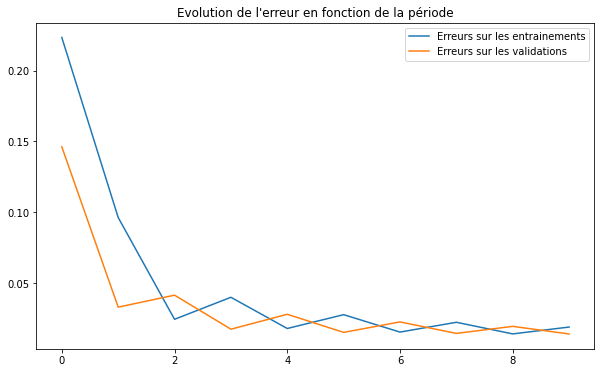

In [9]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

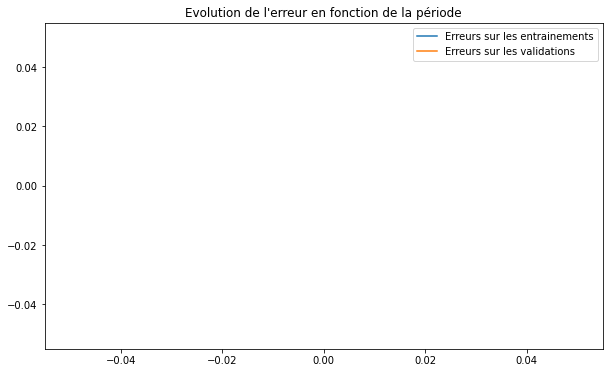

In [177]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [20]:
dataPredict = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

predictions = model.predict(dataPredict)
predictions = tf.reshape(predictions,shape=(predictions.shape[0],1))

In [166]:
predictions.shape

TensorShape([416, 1])

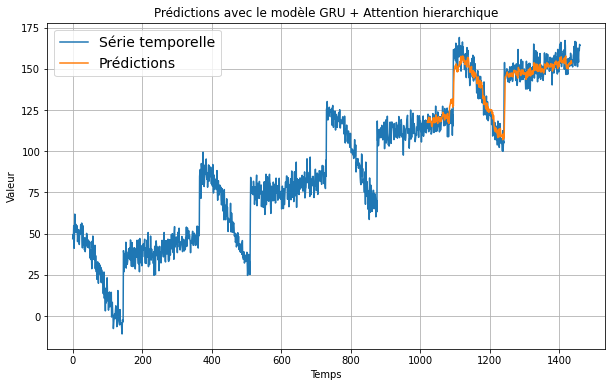

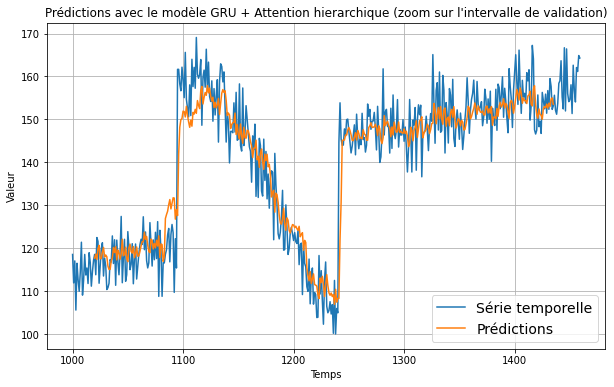

In [21]:
reste = len(temps[temps_separation:])-predictions.shape[0]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")

if reste != 0:
  affiche_serie(temps[temps_separation+taille_fenetre:-reste+taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")


plt.title('Prédictions avec le modèle GRU + Attention hierarchique')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
if reste != 0:
  affiche_serie(temps[temps_separation+taille_fenetre:-reste+taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],np.asarray(predictions*std.numpy()+mean.numpy()),label="Prédictions")
plt.title("Prédictions avec le modèle GRU + Attention hierarchique (zoom sur l'intervalle de validation)")
plt.show()

In [22]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:-reste+taille_fenetre],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:-reste+taille_fenetre],np.asarray(predictions[:,0]*std.numpy()+mean.numpy())).numpy()

print(mae)
print(mse)

4.9914317
44.776245
